In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    ################################################ s', Q = env(s, a)
    ################################################ ~s', ~Q = env(s, ~a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                   labels=next_states_labels))
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels))
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                  action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
#     eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
#                                                                     labels=tf.zeros_like(rates))) # min
#     aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
#                                                                      labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a') # max
    ###################################################### ~Q(s,~a)= r # min
    ###################################################### ~Q(s,~a)= r + Q'(s',a') # max
    targetQs = rewards + (gamma * aQs2_logits)
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0000 rate:0.0420 aloss:0.7003 eloss:2.3959 aloss2:0.6393 exploreP:0.9979
Episode:1 meanR:18.0000 R:15.0000 rate:0.0300 aloss:0.6861 eloss:2.3674 aloss2:0.6511 exploreP:0.9964
Episode:2 meanR:16.3333 R:13.0000 rate:0.0260 aloss:0.7003 eloss:2.3578 aloss2:0.6562 exploreP:0.9952
Episode:3 meanR:15.2500 R:12.0000 rate:0.0240 aloss:0.7087 eloss:2.3579 aloss2:0.6587 exploreP:0.9940
Episode:4 meanR:19.0000 R:34.0000 rate:0.0680 aloss:0.7076 eloss:2.3625 aloss2:0.6529 exploreP:0.9906
Episode:5 meanR:19.6667 R:23.0000 rate:0.0460 aloss:0.7019 eloss:2.3480 aloss2:0.6596 exploreP:0.9884
Episode:6 meanR:22.0000 R:36.0000 rate:0.0720 aloss:0.6892 eloss:2.3360 aloss2:0.6601 exploreP:0.9849
Episode:7 meanR:21.0000 R:14.0000 rate:0.0280 aloss:0.6995 eloss:2.3322 aloss2:0.6632 exploreP:0.9835
Episode:8 meanR:19.7778 R:10.0000 rate:0.0200 aloss:0.6933 eloss:2.3344 aloss2:0.6604 exploreP:0.9825
Episode:9 meanR:20.5000 R:27.0000 rate:0.0540 aloss:0.7047 eloss:2.3271 aloss2:0.6

Episode:80 meanR:26.3457 R:10.0000 rate:0.0200 aloss:0.6894 eloss:1.7651 aloss2:1.1870 exploreP:0.8098
Episode:81 meanR:26.2561 R:19.0000 rate:0.0380 aloss:0.6927 eloss:1.7822 aloss2:1.1892 exploreP:0.8082
Episode:82 meanR:26.0723 R:11.0000 rate:0.0220 aloss:0.6892 eloss:1.7521 aloss2:1.1974 exploreP:0.8074
Episode:83 meanR:26.0238 R:22.0000 rate:0.0440 aloss:0.6896 eloss:1.7432 aloss2:1.2050 exploreP:0.8056
Episode:84 meanR:25.8941 R:15.0000 rate:0.0300 aloss:0.6887 eloss:1.7405 aloss2:1.2047 exploreP:0.8044
Episode:85 meanR:25.7558 R:14.0000 rate:0.0280 aloss:0.6958 eloss:1.7348 aloss2:1.2178 exploreP:0.8033
Episode:86 meanR:25.6092 R:13.0000 rate:0.0260 aloss:0.6896 eloss:1.7390 aloss2:1.2131 exploreP:0.8023
Episode:87 meanR:25.5455 R:20.0000 rate:0.0400 aloss:0.6934 eloss:1.7319 aloss2:1.2150 exploreP:0.8007
Episode:88 meanR:25.4607 R:18.0000 rate:0.0360 aloss:0.6955 eloss:1.7206 aloss2:1.2243 exploreP:0.7993
Episode:89 meanR:25.6333 R:41.0000 rate:0.0820 aloss:0.6942 eloss:1.7090 

Episode:159 meanR:25.3400 R:62.0000 rate:0.1240 aloss:0.6785 eloss:0.8554 aloss2:2.1302 exploreP:0.6635
Episode:160 meanR:25.7100 R:56.0000 rate:0.1120 aloss:0.6785 eloss:0.8167 aloss2:2.1627 exploreP:0.6599
Episode:161 meanR:25.6900 R:30.0000 rate:0.0600 aloss:0.6700 eloss:0.7761 aloss2:2.1946 exploreP:0.6579
Episode:162 meanR:25.7300 R:71.0000 rate:0.1420 aloss:0.6790 eloss:0.8083 aloss2:2.2491 exploreP:0.6534
Episode:163 meanR:26.2000 R:71.0000 rate:0.1420 aloss:0.6706 eloss:0.7309 aloss2:2.2769 exploreP:0.6488
Episode:164 meanR:26.6200 R:92.0000 rate:0.1840 aloss:0.6823 eloss:0.7243 aloss2:2.3473 exploreP:0.6430
Episode:165 meanR:27.5400 R:118.0000 rate:0.2360 aloss:0.6815 eloss:0.6333 aloss2:2.4360 exploreP:0.6355
Episode:166 meanR:27.4300 R:32.0000 rate:0.0640 aloss:0.6903 eloss:0.6123 aloss2:2.4797 exploreP:0.6335
Episode:167 meanR:27.3600 R:10.0000 rate:0.0200 aloss:0.6821 eloss:0.5515 aloss2:2.5241 exploreP:0.6329
Episode:168 meanR:27.1900 R:26.0000 rate:0.0520 aloss:0.6835 el

Episode:237 meanR:107.9300 R:42.0000 rate:0.0840 aloss:0.7347 eloss:-4.2014 aloss2:14.0153 exploreP:0.2507
Episode:238 meanR:108.0500 R:36.0000 rate:0.0720 aloss:0.7135 eloss:-3.7680 aloss2:14.0398 exploreP:0.2498
Episode:239 meanR:108.3600 R:48.0000 rate:0.0960 aloss:0.7308 eloss:-4.3415 aloss2:14.1387 exploreP:0.2487
Episode:240 meanR:113.1000 R:500.0000 rate:1.0000 aloss:0.7331 eloss:-3.9070 aloss2:14.5258 exploreP:0.2370
Episode:241 meanR:113.8700 R:91.0000 rate:0.1820 aloss:0.7361 eloss:-4.2640 aloss2:14.9164 exploreP:0.2350
Episode:242 meanR:113.9300 R:25.0000 rate:0.0500 aloss:0.7242 eloss:-2.1742 aloss2:15.0035 exploreP:0.2344
Episode:243 meanR:113.9500 R:31.0000 rate:0.0620 aloss:0.7349 eloss:-3.4478 aloss2:15.0007 exploreP:0.2337
Episode:244 meanR:115.1300 R:139.0000 rate:0.2780 aloss:0.7354 eloss:-3.9441 aloss2:15.1630 exploreP:0.2306
Episode:245 meanR:115.6300 R:66.0000 rate:0.1320 aloss:0.7321 eloss:-4.0537 aloss2:15.3069 exploreP:0.2292
Episode:246 meanR:115.1400 R:10.000

Episode:314 meanR:148.1600 R:500.0000 rate:1.0000 aloss:0.7696 eloss:-3.6963 aloss2:19.9371 exploreP:0.0910
Episode:315 meanR:148.1300 R:37.0000 rate:0.0740 aloss:0.7799 eloss:-3.9642 aloss2:20.0385 exploreP:0.0907
Episode:316 meanR:152.9400 R:500.0000 rate:1.0000 aloss:0.7601 eloss:-4.1479 aloss2:20.1205 exploreP:0.0867
Episode:317 meanR:157.4900 R:500.0000 rate:1.0000 aloss:0.7774 eloss:-4.6099 aloss2:20.2915 exploreP:0.0830
Episode:318 meanR:159.8700 R:321.0000 rate:0.6420 aloss:0.7703 eloss:-4.4410 aloss2:20.4673 exploreP:0.0807
Episode:319 meanR:161.4000 R:500.0000 rate:1.0000 aloss:0.7709 eloss:-4.2859 aloss2:20.7333 exploreP:0.0772
Episode:320 meanR:166.0300 R:500.0000 rate:1.0000 aloss:0.7587 eloss:-4.1605 aloss2:20.9727 exploreP:0.0740
Episode:321 meanR:167.9700 R:500.0000 rate:1.0000 aloss:0.7606 eloss:-3.8194 aloss2:21.1348 exploreP:0.0708
Episode:322 meanR:169.7100 R:500.0000 rate:1.0000 aloss:0.7587 eloss:-4.6006 aloss2:21.2948 exploreP:0.0679
Episode:323 meanR:172.3800 R:

Episode:390 meanR:386.8100 R:500.0000 rate:1.0000 aloss:0.5779 eloss:-2.4742 aloss2:20.3770 exploreP:0.0129
Episode:391 meanR:391.0700 R:500.0000 rate:1.0000 aloss:0.5884 eloss:-1.9307 aloss2:20.2718 exploreP:0.0128
Episode:392 meanR:393.9800 R:500.0000 rate:1.0000 aloss:0.5869 eloss:-2.1254 aloss2:20.1201 exploreP:0.0126
Episode:393 meanR:398.8800 R:500.0000 rate:1.0000 aloss:0.5825 eloss:-1.8424 aloss2:20.0277 exploreP:0.0125
Episode:394 meanR:403.7600 R:500.0000 rate:1.0000 aloss:0.5749 eloss:-1.9072 aloss2:19.9248 exploreP:0.0124
Episode:395 meanR:408.6500 R:500.0000 rate:1.0000 aloss:0.5801 eloss:-1.8660 aloss2:19.9679 exploreP:0.0123
Episode:396 meanR:413.4500 R:500.0000 rate:1.0000 aloss:0.5725 eloss:-2.0623 aloss2:19.9202 exploreP:0.0122
Episode:397 meanR:418.3500 R:500.0000 rate:1.0000 aloss:0.5761 eloss:-1.6668 aloss2:19.8122 exploreP:0.0121
Episode:398 meanR:421.4900 R:500.0000 rate:1.0000 aloss:0.5933 eloss:-2.5200 aloss2:19.8301 exploreP:0.0120
Episode:399 meanR:424.3000 R

Episode:467 meanR:461.9000 R:500.0000 rate:1.0000 aloss:0.4527 eloss:1.3172 aloss2:16.5257 exploreP:0.0101
Episode:468 meanR:461.9000 R:500.0000 rate:1.0000 aloss:0.4465 eloss:1.6648 aloss2:16.2875 exploreP:0.0101
Episode:469 meanR:461.9000 R:500.0000 rate:1.0000 aloss:0.4420 eloss:1.5857 aloss2:16.0809 exploreP:0.0101
Episode:470 meanR:457.1700 R:27.0000 rate:0.0540 aloss:0.4957 eloss:0.1990 aloss2:16.0229 exploreP:0.0101
Episode:471 meanR:457.1700 R:500.0000 rate:1.0000 aloss:0.4405 eloss:1.5343 aloss2:15.8186 exploreP:0.0101
Episode:472 meanR:454.5600 R:239.0000 rate:0.4780 aloss:0.4189 eloss:2.0036 aloss2:15.5718 exploreP:0.0101
Episode:473 meanR:454.5600 R:500.0000 rate:1.0000 aloss:0.4377 eloss:1.4641 aloss2:15.4839 exploreP:0.0101
Episode:474 meanR:454.5600 R:500.0000 rate:1.0000 aloss:0.4340 eloss:1.7416 aloss2:15.2748 exploreP:0.0101
Episode:475 meanR:454.9700 R:500.0000 rate:1.0000 aloss:0.4172 eloss:1.8444 aloss2:14.9542 exploreP:0.0101
Episode:476 meanR:454.9700 R:500.0000 

Episode:545 meanR:416.4300 R:500.0000 rate:1.0000 aloss:0.4296 eloss:1.8037 aloss2:3.9332 exploreP:0.0100
Episode:546 meanR:415.2700 R:384.0000 rate:0.7680 aloss:0.4315 eloss:1.8025 aloss2:3.9310 exploreP:0.0100
Episode:547 meanR:412.4100 R:214.0000 rate:0.4280 aloss:0.4305 eloss:1.8009 aloss2:3.9342 exploreP:0.0100
Episode:548 meanR:412.4100 R:500.0000 rate:1.0000 aloss:0.4295 eloss:1.7992 aloss2:3.9358 exploreP:0.0100
Episode:549 meanR:412.4100 R:500.0000 rate:1.0000 aloss:0.4302 eloss:1.8008 aloss2:3.9368 exploreP:0.0100
Episode:550 meanR:417.1400 R:500.0000 rate:1.0000 aloss:0.4298 eloss:1.7986 aloss2:3.9411 exploreP:0.0100
Episode:551 meanR:421.9300 R:500.0000 rate:1.0000 aloss:0.4323 eloss:1.7986 aloss2:3.9436 exploreP:0.0100
Episode:552 meanR:421.9300 R:500.0000 rate:1.0000 aloss:0.4316 eloss:1.7974 aloss2:3.9450 exploreP:0.0100
Episode:553 meanR:421.9300 R:500.0000 rate:1.0000 aloss:0.4316 eloss:1.7975 aloss2:3.9407 exploreP:0.0100
Episode:554 meanR:421.9300 R:500.0000 rate:1.0

Episode:623 meanR:473.5900 R:500.0000 rate:1.0000 aloss:0.3960 eloss:1.5902 aloss2:4.7401 exploreP:0.0100
Episode:624 meanR:473.5900 R:500.0000 rate:1.0000 aloss:0.3955 eloss:1.5927 aloss2:4.7508 exploreP:0.0100
Episode:625 meanR:473.5900 R:500.0000 rate:1.0000 aloss:0.3956 eloss:1.5894 aloss2:4.7621 exploreP:0.0100
Episode:626 meanR:476.5500 R:500.0000 rate:1.0000 aloss:0.3949 eloss:1.5865 aloss2:4.7698 exploreP:0.0100
Episode:627 meanR:477.3800 R:500.0000 rate:1.0000 aloss:0.3968 eloss:1.5873 aloss2:4.7893 exploreP:0.0100
Episode:628 meanR:477.3800 R:500.0000 rate:1.0000 aloss:0.3938 eloss:1.5809 aloss2:4.7971 exploreP:0.0100
Episode:629 meanR:477.3800 R:500.0000 rate:1.0000 aloss:0.3956 eloss:1.5810 aloss2:4.8286 exploreP:0.0100
Episode:630 meanR:480.6900 R:500.0000 rate:1.0000 aloss:0.3945 eloss:1.5790 aloss2:4.8542 exploreP:0.0100
Episode:631 meanR:481.7500 R:500.0000 rate:1.0000 aloss:0.3945 eloss:1.5791 aloss2:4.8908 exploreP:0.0100
Episode:632 meanR:483.4600 R:500.0000 rate:1.0

Episode:701 meanR:491.9400 R:500.0000 rate:1.0000 aloss:0.3886 eloss:1.5802 aloss2:5.3531 exploreP:0.0100
Episode:702 meanR:491.9400 R:500.0000 rate:1.0000 aloss:0.3889 eloss:1.5811 aloss2:5.3547 exploreP:0.0100
Episode:703 meanR:491.2400 R:430.0000 rate:0.8600 aloss:0.3891 eloss:1.5838 aloss2:5.3576 exploreP:0.0100
Episode:704 meanR:491.2400 R:500.0000 rate:1.0000 aloss:0.3890 eloss:1.5814 aloss2:5.3530 exploreP:0.0100
Episode:705 meanR:491.2400 R:500.0000 rate:1.0000 aloss:0.3893 eloss:1.5769 aloss2:5.3567 exploreP:0.0100
Episode:706 meanR:491.2400 R:500.0000 rate:1.0000 aloss:0.3899 eloss:1.5837 aloss2:5.3560 exploreP:0.0100
Episode:707 meanR:491.2400 R:500.0000 rate:1.0000 aloss:0.3909 eloss:1.5811 aloss2:5.3532 exploreP:0.0100
Episode:708 meanR:491.2400 R:500.0000 rate:1.0000 aloss:0.3885 eloss:1.5828 aloss2:5.3565 exploreP:0.0100
Episode:709 meanR:491.2400 R:500.0000 rate:1.0000 aloss:0.3883 eloss:1.5853 aloss2:5.3494 exploreP:0.0100
Episode:710 meanR:491.2400 R:500.0000 rate:1.0

Episode:779 meanR:477.9900 R:10.0000 rate:0.0200 aloss:0.3593 eloss:1.1062 aloss2:5.8095 exploreP:0.0100
Episode:780 meanR:477.9900 R:500.0000 rate:1.0000 aloss:0.3782 eloss:1.0854 aloss2:5.8632 exploreP:0.0100
Episode:781 meanR:477.9900 R:500.0000 rate:1.0000 aloss:0.3782 eloss:1.0786 aloss2:5.8995 exploreP:0.0100
Episode:782 meanR:477.9900 R:500.0000 rate:1.0000 aloss:0.3765 eloss:1.0690 aloss2:5.9332 exploreP:0.0100
Episode:783 meanR:477.9900 R:500.0000 rate:1.0000 aloss:0.3766 eloss:1.0714 aloss2:5.9745 exploreP:0.0100
Episode:784 meanR:477.9900 R:500.0000 rate:1.0000 aloss:0.3780 eloss:1.0832 aloss2:6.0096 exploreP:0.0100
Episode:785 meanR:473.0900 R:10.0000 rate:0.0200 aloss:0.3939 eloss:1.0853 aloss2:6.0109 exploreP:0.0100
Episode:786 meanR:473.0900 R:500.0000 rate:1.0000 aloss:0.3754 eloss:1.0617 aloss2:6.0271 exploreP:0.0100
Episode:787 meanR:468.1900 R:10.0000 rate:0.0200 aloss:0.3851 eloss:1.0572 aloss2:6.0573 exploreP:0.0100
Episode:788 meanR:469.2500 R:500.0000 rate:1.0000

Episode:857 meanR:426.6200 R:500.0000 rate:1.0000 aloss:0.3304 eloss:0.7472 aloss2:8.3376 exploreP:0.0100
Episode:858 meanR:426.6200 R:500.0000 rate:1.0000 aloss:0.3304 eloss:0.7403 aloss2:8.3629 exploreP:0.0100
Episode:859 meanR:421.7200 R:10.0000 rate:0.0200 aloss:0.3252 eloss:0.7569 aloss2:8.4404 exploreP:0.0100
Episode:860 meanR:421.7200 R:500.0000 rate:1.0000 aloss:0.3301 eloss:0.7408 aloss2:8.3881 exploreP:0.0100
Episode:861 meanR:416.8300 R:11.0000 rate:0.0220 aloss:0.3294 eloss:0.7737 aloss2:8.4305 exploreP:0.0100
Episode:862 meanR:416.8300 R:500.0000 rate:1.0000 aloss:0.3301 eloss:0.7508 aloss2:8.4151 exploreP:0.0100
Episode:863 meanR:416.8300 R:500.0000 rate:1.0000 aloss:0.3311 eloss:0.7293 aloss2:8.4459 exploreP:0.0100
Episode:864 meanR:416.8300 R:500.0000 rate:1.0000 aloss:0.3287 eloss:0.7352 aloss2:8.4689 exploreP:0.0100
Episode:865 meanR:416.8300 R:500.0000 rate:1.0000 aloss:0.3298 eloss:0.7246 aloss2:8.4789 exploreP:0.0100
Episode:866 meanR:416.8300 R:500.0000 rate:1.000

Episode:935 meanR:352.4400 R:500.0000 rate:1.0000 aloss:0.3128 eloss:0.6258 aloss2:9.3745 exploreP:0.0100
Episode:936 meanR:354.7400 R:500.0000 rate:1.0000 aloss:0.3130 eloss:0.6311 aloss2:9.4147 exploreP:0.0100
Episode:937 meanR:354.7400 R:500.0000 rate:1.0000 aloss:0.3121 eloss:0.6201 aloss2:9.4192 exploreP:0.0100
Episode:938 meanR:354.7400 R:500.0000 rate:1.0000 aloss:0.3118 eloss:0.6303 aloss2:9.4201 exploreP:0.0100
Episode:939 meanR:349.8400 R:10.0000 rate:0.0200 aloss:0.3099 eloss:0.5969 aloss2:9.3940 exploreP:0.0100
Episode:940 meanR:349.8400 R:500.0000 rate:1.0000 aloss:0.3127 eloss:0.6524 aloss2:9.4506 exploreP:0.0100
Episode:941 meanR:349.8400 R:500.0000 rate:1.0000 aloss:0.3105 eloss:0.6143 aloss2:9.4293 exploreP:0.0100
Episode:942 meanR:354.7400 R:500.0000 rate:1.0000 aloss:0.3106 eloss:0.6153 aloss2:9.4442 exploreP:0.0100
Episode:943 meanR:359.6400 R:500.0000 rate:1.0000 aloss:0.3109 eloss:0.6161 aloss2:9.4740 exploreP:0.0100
Episode:944 meanR:354.7400 R:10.0000 rate:0.020

Episode:1013 meanR:402.3500 R:500.0000 rate:1.0000 aloss:0.3018 eloss:0.5182 aloss2:10.1864 exploreP:0.0100
Episode:1014 meanR:407.2400 R:500.0000 rate:1.0000 aloss:0.3011 eloss:0.5039 aloss2:10.1809 exploreP:0.0100
Episode:1015 meanR:407.2400 R:500.0000 rate:1.0000 aloss:0.3012 eloss:0.5131 aloss2:10.1964 exploreP:0.0100
Episode:1016 meanR:407.2400 R:500.0000 rate:1.0000 aloss:0.3000 eloss:0.4964 aloss2:10.1913 exploreP:0.0100
Episode:1017 meanR:412.0600 R:500.0000 rate:1.0000 aloss:0.3002 eloss:0.5103 aloss2:10.2223 exploreP:0.0100
Episode:1018 meanR:412.0600 R:500.0000 rate:1.0000 aloss:0.2990 eloss:0.5023 aloss2:10.2050 exploreP:0.0100
Episode:1019 meanR:412.0600 R:500.0000 rate:1.0000 aloss:0.2997 eloss:0.5247 aloss2:10.2411 exploreP:0.0100
Episode:1020 meanR:416.9600 R:500.0000 rate:1.0000 aloss:0.2990 eloss:0.4986 aloss2:10.1969 exploreP:0.0100
Episode:1021 meanR:416.9600 R:500.0000 rate:1.0000 aloss:0.2982 eloss:0.4927 aloss2:10.2097 exploreP:0.0100
Episode:1022 meanR:416.9600 

Episode:1089 meanR:490.2000 R:500.0000 rate:1.0000 aloss:0.2908 eloss:0.4784 aloss2:11.4407 exploreP:0.0100
Episode:1090 meanR:490.2000 R:500.0000 rate:1.0000 aloss:0.2914 eloss:0.4879 aloss2:11.4467 exploreP:0.0100
Episode:1091 meanR:490.2000 R:500.0000 rate:1.0000 aloss:0.2902 eloss:0.4989 aloss2:11.4617 exploreP:0.0100
Episode:1092 meanR:495.1000 R:500.0000 rate:1.0000 aloss:0.2902 eloss:0.4711 aloss2:11.4937 exploreP:0.0100
Episode:1093 meanR:495.1000 R:500.0000 rate:1.0000 aloss:0.2899 eloss:0.4671 aloss2:11.4731 exploreP:0.0100
Episode:1094 meanR:495.1000 R:500.0000 rate:1.0000 aloss:0.2901 eloss:0.4972 aloss2:11.5076 exploreP:0.0100
Episode:1095 meanR:495.1000 R:500.0000 rate:1.0000 aloss:0.2895 eloss:0.4898 aloss2:11.4926 exploreP:0.0100
Episode:1096 meanR:495.1000 R:500.0000 rate:1.0000 aloss:0.2896 eloss:0.4823 aloss2:11.5005 exploreP:0.0100
Episode:1097 meanR:495.1000 R:500.0000 rate:1.0000 aloss:0.2888 eloss:0.4770 aloss2:11.4950 exploreP:0.0100
Episode:1098 meanR:495.1000 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

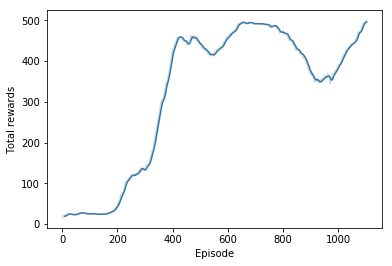

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

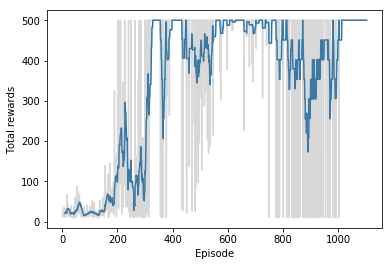

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

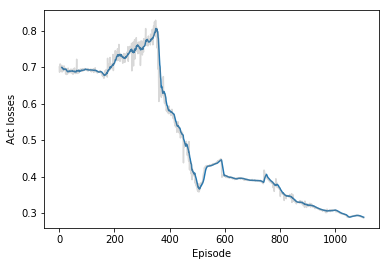

In [18]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

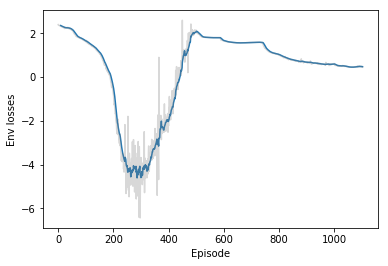

In [19]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

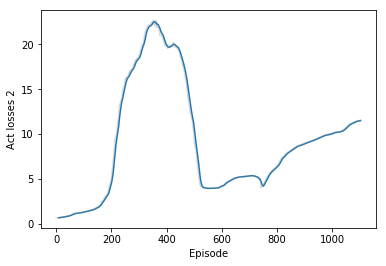

In [20]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
